In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
wget https://raw.githubusercontent.com/guiwitz/neubias_academy_biapy/master/course_functions.py

# 16. Complete analysis pipeline

In [146]:
import os, re, glob
import skimage
import skimage.io
import skimage.filters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.io import imread

from course_functions import random_cmap
cmap = random_cmap()

This notebook reproduces the result of the live coding demo that was shown in the NEUBIAS@Home webinar of the 13th of May that you can find on [Youtube](https://www.youtube.com/watch?v=Y3pB3wnOivE). The goal was to show how to create a small analysis pipeline, not focusing on the segmentation itself but rather on data handling and analysis.

The [dataset](https://data.broadinstitute.org/bbbc/BBBC013/) used here comes from the Broad Bioimage Benchmark Collection. It consists in cell images acquired by fluorescence microscopy on a 96-well plate. Two channels are acquired: one to detect nuclei and one to measure fluorescence of a tagged protein that can be located in the cytoplasm or the nuclei. The location of that protein can be modified by adding a drug to the media.

The goal here is to import the data from the 96-well plate, segment all nuclei, and measure the intensity within those nuclei in the other channel. We will see if we can deduce how the drug treatment was done without knowing it in beforehand.

## 1. Develop pipeline on single file

First, we define the location of the data and then import a single image of tagged nuclei:

In [147]:
mainpath = '/content/drive/My Drive/Data/BBBC013_v1_images_bmp'

In [148]:
image2 = skimage.io.imread(mainpath + '/Channel2-01-A-01.BMP')

Note that a better way to "assemble" paths, like here with a main folder and a file, is to use ```os.path``` or ```patlib```. This prevents problems related to path formatting on different operating systems. For example:

In [149]:
image2 = skimage.io.imread(os.path.join(mainpath, 'Channel2-01-A-01.BMP'))

We don't want to demonstrate a perfect segmentation. So we'll use a crude thresholding. In order to test which automated thresholding works better, we can make use of the ```try_all_threshold``` function:

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


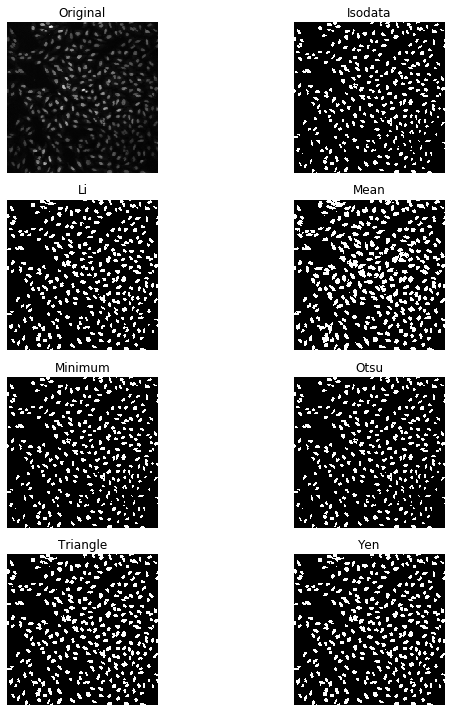

In [150]:
skimage.filters.try_all_threshold(image2,figsize=(10,10));

It seems that the Otsu method gives a reasonable result. Let's calculate a mask and plot the result:

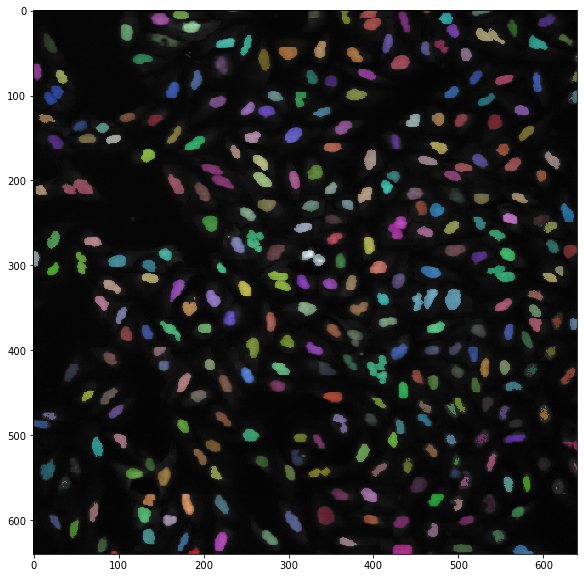

In [151]:
threshold = skimage.filters.threshold_otsu(image2)
mask = image2 > threshold

plt.figure(figsize=(10,10))
plt.imshow(image2, cmap = 'gray')
plt.imshow(skimage.measure.label(mask),cmap = cmap);

Finally we want to measure the intensity within the nucleus in the **other channel**. So we need to import the second image as well:

In [152]:
image1 = skimage.io.imread(os.path.join(mainpath, 'Channel1-01-A-01.BMP'))

And we can now measure the region properties of the mask **with** the Channel1 image as ```intensity_image```:

In [153]:
regions = skimage.measure.regionprops_table(skimage.measure.label(mask), intensity_image=image1,
                                           properties=('label','area','mean_intensity'))

Finally to simplify our data analysis work we transform the resulting dictionary into a pandas dataframe:

In [154]:
regions_pd = pd.DataFrame(regions)

In [155]:
regions_pd

,label,area,mean_intensity
0,1,23,56.043478
1,2,115,44.026087
2,3,123,33.609756
3,4,388,8.724227
4,5,21,3.428571
...,...,...,...
320,321,178,18.601124
321,322,230,19.117391
322,323,157,22.292994
323,324,57,9.245614


Our goal now will be to apply the same processing to all images. We will therefore end-up with a series of such dataframes, and we'll need a way to know which one corresponds to which well in the 96-well plate. So we can try to extract that information from the filename itself. For that we will use [*regular expressions*](https://docs.python.org/3/library/re.html), a powerful way to identify patterns in strings. Our filename is e.g. ```Channel1-01-A-01.BMP```. The structure of that name is ```something-something-something-something.BMP``` where the two last *somethings* are the well coordinate. In regular expressions, the dot ```.``` means "*any character*"  and the ```+``` signs means "*appears 1 or more times*", and therefore ```.+``` means *one ore more times any character*. So we are looking for a pattern of the type: ```.+-.+-.+-.+\.BMP``` (the ```\``` indicates that the following ```.``` sign really is the dot character). Finally we can enclose the part of the pattern we want to recover in parenthesis and use the ```re``` module to detect the pattern:

In [156]:
re.findall('.+-.+-(.+)-.+\.BMP','Channel1-01-A-01.BMP')

['A']

In [157]:
re.findall('.+-.+-.+-(.+)\.BMP','Channel1-01-A-01.BMP')

['01']

In each case, we recover the first and only element of the list. Additionally, we transform the well column into a number:

In [158]:
int(re.findall('.+-.+-.+-(.+)\.BMP','Channel1-01-A-01.BMP')[0])

1

We can then add that information to our dataframe so that we know to which well it corresponds:

In [159]:
regions_pd['platerow'] = re.findall('.+-.+-(.+)-.+\.BMP','Channel1-01-A-01.BMP')[0]
regions_pd['platecol'] = int(re.findall('.+-.+-.+-(.+)\.BMP','Channel1-01-A-01.BMP')[0])
regions_pd['filename'] = 'Channel1-01-A-01.BMP'

In [160]:
regions_pd

,label,area,mean_intensity,platerow,platecol,filename
0,1,23,56.043478,A,1,Channel1-01-A-01.BMP
1,2,115,44.026087,A,1,Channel1-01-A-01.BMP
2,3,123,33.609756,A,1,Channel1-01-A-01.BMP
3,4,388,8.724227,A,1,Channel1-01-A-01.BMP
4,5,21,3.428571,A,1,Channel1-01-A-01.BMP
...,...,...,...,...,...,...
320,321,178,18.601124,A,1,Channel1-01-A-01.BMP
321,322,230,19.117391,A,1,Channel1-01-A-01.BMP
322,323,157,22.292994,A,1,Channel1-01-A-01.BMP
323,324,57,9.245614,A,1,Channel1-01-A-01.BMP


## Adapt the pipeline for *all* images

Now that we have a working pipeline for a single pipeline, we can extend it to all images. Therefore we first need to recover all filenames present in the data folder. There are multiple ways of doing that, the more general way being again to use the ```pathlib``` module. Alternatively, in simple cases, one can use the ```glob``` module which allows to define simple file patterns (not regular expressions). For example to recover all file names that contain *Channel1* we can write:

In [161]:
channel1 = glob.glob(os.path.join(mainpath,'Channel1*'))
channel1[0:5]

['/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-22-B-10.BMP',
 '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-66-F-06.BMP',
 '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-02-A-02.BMP',
 '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-94-H-10.BMP',
 '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-03-A-03.BMP']

We can also sort the list using ```np.sort```. Note that sorting in this case is easy because file names have been nicely formatted e.g. the numbering is always composed of two digits (starting with 0 for single digits). If the formatting is not as nice, you might have again to use regular expressions to properly order the file names:

In [162]:
channel1 = np.sort(glob.glob(os.path.join(mainpath,'Channel1*')))
channel1[0:5]

array(['/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-01-A-01.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-02-A-02.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-03-A-03.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-04-A-04.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-05-A-05.BMP'], dtype='<U50')

We can repeat the same command to gather all files for *Channel2*. As both lists contain exactly the same file names, they will be sorted in the same way, an therefore we can be sure that the file #1 from each list corresponds to the same well.

In [163]:
channel2 = np.sort(glob.glob(os.path.join(mainpath,'Channel2*')))
channel2[0:5]

array(['/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel2-01-A-01.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel2-02-A-02.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel2-03-A-03.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel2-04-A-04.BMP',
       '/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel2-05-A-05.BMP'], dtype='<U50')

If we want to re-use our previously defined regular expression and add just the file name (without complete path) to our dataframes, we finally need to split that path:

In [164]:
channel1[0]

'/content/drive/My Drive/Data/BBBC013_v1_images_bmp/Channel1-01-A-01.BMP'

In [165]:
channel1[0].split('/')

['..', 'Data', 'BBBC013_v1_images_bmp', 'Channel1-01-A-01.BMP']

In [166]:
filename = channel1[0].split('/')[-1]
filename

'Channel1-01-A-01.BMP'

We can finally combine all these steps in a simple ```for``` loop. We will collect the dataframes for each well into a list called ```results```:

In [167]:
results = []
# create an index that allows us to go through each pair of images
for ind in range(len(channel1)):
    
    # load the imgages of each channel
    image1 = skimage.io.imread(channel1[ind])
    image2 = skimage.io.imread(channel2[ind])
    
    # create a mask by thresholding and label it
    mask = image2 > skimage.filters.threshold_otsu(image2)
    labels = skimage.measure.label(mask)
    
    # measure region properties using channel1 as intensity image
    regions = skimage.measure.regionprops_table(labels, image1, properties=('label','mean_intensity'))
    
    # turn results into a dataframe
    regions = pd.DataFrame(regions)
    
    # recover the filename and add it to the dataframe
    filename = channel1[ind].split('/')[-1]
    regions['file'] = filename
    
    # recover the well row and column using regular expressions
    regions['platerow'] = re.findall('.+-.+-(.+)-.+\.BMP',filename)[0]
    regions['platecol'] = int(re.findall('.+-.+-.+-(.+)\.BMP',filename)[0])
    
    # append the dataframe to the results list
    results.append(regions)

We can have a look at one of the dataframes to check that everything worked as eexpected:

In [168]:
results[20]

,label,mean_intensity,file,platerow,platecol
0,1,81.957746,Channel1-21-B-09.BMP,B,9
1,2,29.166667,Channel1-21-B-09.BMP,B,9
2,3,20.993103,Channel1-21-B-09.BMP,B,9
3,4,110.564767,Channel1-21-B-09.BMP,B,9
4,5,96.179775,Channel1-21-B-09.BMP,B,9
...,...,...,...,...,...
177,178,91.598592,Channel1-21-B-09.BMP,B,9
178,179,176.781250,Channel1-21-B-09.BMP,B,9
179,180,129.585366,Channel1-21-B-09.BMP,B,9
180,181,9.416667,Channel1-21-B-09.BMP,B,9


We want to analyze the plate as *one* experiment. As we have the reference to the well position in each dataframe we can therefore combined them into one large dataframe without loosing information and that we can then analyze using Pandas tools:

In [169]:
all_results = pd.concat(results)

In [170]:
all_results

,label,mean_intensity,file,platerow,platecol
0,1,56.043478,Channel1-01-A-01.BMP,A,1
1,2,44.026087,Channel1-01-A-01.BMP,A,1
2,3,33.609756,Channel1-01-A-01.BMP,A,1
3,4,8.724227,Channel1-01-A-01.BMP,A,1
4,5,3.428571,Channel1-01-A-01.BMP,A,1
...,...,...,...,...,...
254,255,21.261194,Channel1-96-H-12.BMP,H,12
255,256,59.857143,Channel1-96-H-12.BMP,H,12
256,257,36.970000,Channel1-96-H-12.BMP,H,12
257,258,4.232558,Channel1-96-H-12.BMP,H,12


## Data analysis

Now that we have *extracted* information form our images, we can proceed with the analysis itself. To get a first idea of how the data look like, we can simply group the data by file name and calculate the mean. This will give us an overview. To do that we can use the "split-apply-group" philosophy of Pandas: 1) we group elements of the dataframe by the content of a given column (here ```file```) using the ```groupby``` function, 2) we apply a function to each group, here a simple ```mean```, 3) this automatically *combines* the means into a new dataframe: 

In [171]:
grouped = all_results.groupby('file', as_index=False).mean()

In [172]:
grouped

,file,label,mean_intensity,platecol
0,Channel1-01-A-01.BMP,163.0,22.007785,1.0
1,Channel1-02-A-02.BMP,133.0,26.829120,2.0
2,Channel1-03-A-03.BMP,123.0,34.067944,3.0
3,Channel1-04-A-04.BMP,105.5,38.403205,4.0
4,Channel1-05-A-05.BMP,117.0,41.634361,5.0
...,...,...,...,...
91,Channel1-92-H-08.BMP,89.0,70.834387,8.0
92,Channel1-93-H-09.BMP,116.0,59.930971,9.0
93,Channel1-94-H-10.BMP,78.0,72.448739,10.0
94,Channel1-95-H-11.BMP,131.0,77.204863,11.0


We used the ```as_index=False``` to avoid getting the file name as an index to the dataframe. We can now plot the resulting means for each file and use the file name as tick-label:

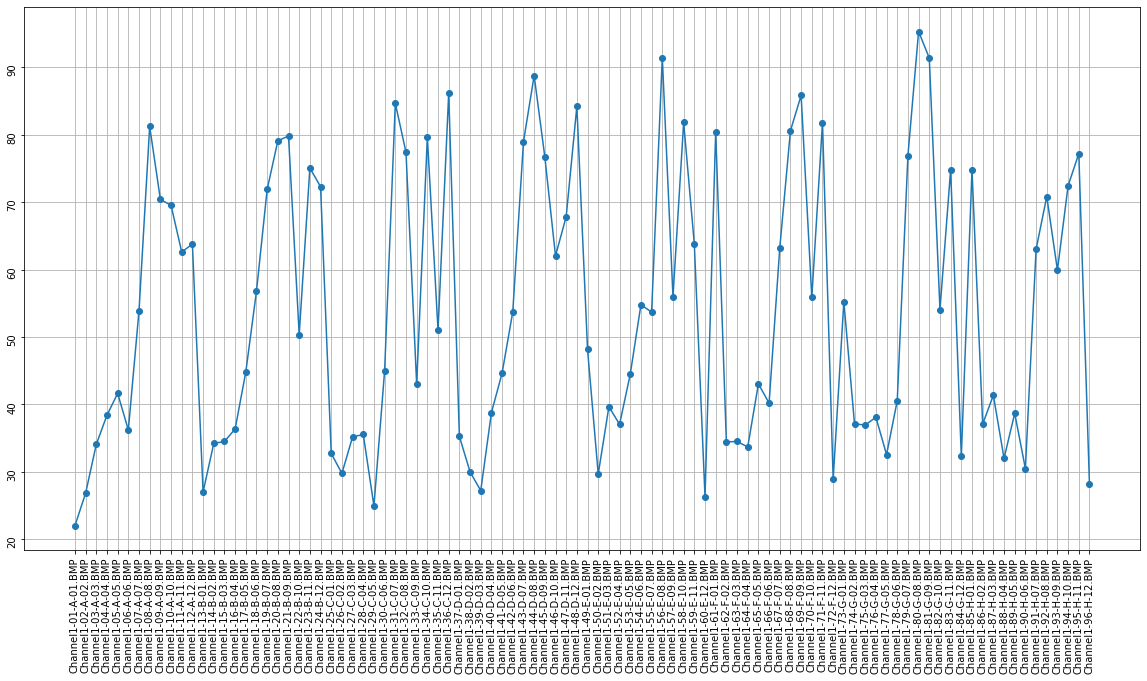

In [175]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(grouped.file, grouped.mean_intensity,'-o')
ax.grid()
ax.tick_params(labelrotation=90)

This is not very readable, but at least we get some interesting hints. For example it looks like for each well there is an increase in intensity in successive columns. So maybe increasing amounts of drug have been added to each well.

To get a better visualization, we can group data by plate row **and** plate column, so that we can create an *intensity vs. column* plot:

In [176]:
grouped = all_results.groupby(['platerow','platecol']).mean()

In [177]:
grouped

label  mean_intensity
platerow platecol                       
A        1         163.0       22.007785
         2         133.0       26.829120
         3         123.0       34.067944
         4         105.5       38.403205
         5         117.0       41.634361
...                  ...             ...
H        8          89.0       70.834387
         9         116.0       59.930971
         10         78.0       72.448739
         11        131.0       77.204863
         12        130.0       28.122616

[96 rows x 2 columns]

Our grouping operation has created a dataframe with a multi-index, one for ```platerow```, one for ```platecol```. Ideally we would like to have a simple two dimensional table for plotting. We can do that by *unstacking* our dataframe, and keeping only the ```mean_intensity``` field. We also specify that we want the ```level=0``` multi-index to become our new columns (the plate rows here):

In [178]:
unstacked = grouped['mean_intensity'].unstack(level = 0)
unstacked

platerow,A,B,C,D,E,F,G,H
platecol,,,,,,,,
1,22.007785,27.014103,32.721287,35.245976,48.164672,80.451699,55.241697,74.797685
2,26.829120,34.213341,29.772399,29.988662,29.663847,34.440647,37.120018,37.087828
3,34.067944,34.503974,35.180628,27.213654,39.652944,34.502551,36.939858,41.356561
4,38.403205,36.356631,35.541339,38.783109,37.052030,33.693977,38.093747,32.005378
5,41.634361,44.807867,24.938727,44.653569,44.492203,43.057715,32.556543,38.676738
6,36.220007,56.800577,45.012660,53.743115,54.789356,40.182654,40.544012,30.472249
7,53.868620,71.889708,84.675630,78.957502,53.694186,63.216249,76.905109,63.005415
8,81.230681,79.096091,77.405535,88.777998,91.445495,80.608208,95.315720,70.834387
9,70.417054,79.827740,43.022053,76.726886,55.965774,85.845389,91.394182,59.930971


Finally we can plot that large table:

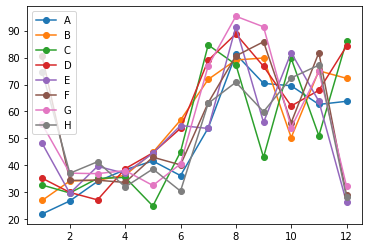

In [184]:
fig, ax = plt.subplots()
platerows = ax.plot(unstacked,'-o')
ax.legend(platerows, unstacked.keys().values);

So we do see an increase in fluorescence across well columns. We also see that rows A,B,C,D have first low-point and a last high-point, while the reverse is true for rows E,F,G,H.

If we check [here](https://data.broadinstitute.org/bbbc/BBBC013/) we see that these observations perfectly correspond to the experiment where an increasing drug dose has been given across columns and where positive/negative controls in the first and last colum have been revered between to top and bottom halves of the plate.

## Alternative plotting

There are many libraries that allow for very efficient plotting of complex data like dataframes. Most follow up to some level the ggplot logic of passing a dataset in the form of a dataframe to a function and specifying then which columns to plot in what plot type. One popular library is [seaborn](https://seaborn.pydata.org/index.html). We'll use here a dataframe where grouping and mean has been done without creation of new indices:

In [185]:
import seaborn as sns

In [186]:
grouped = all_results.groupby(['platerow','platecol'], as_index=False).mean()#.reset_index()

In [187]:
grouped

,platerow,platecol,label,mean_intensity
0,A,1,163.0,22.007785
1,A,2,133.0,26.829120
2,A,3,123.0,34.067944
3,A,4,105.5,38.403205
4,A,5,117.0,41.634361
...,...,...,...,...
91,H,8,89.0,70.834387
92,H,9,116.0,59.930971
93,H,10,78.0,72.448739
94,H,11,131.0,77.204863


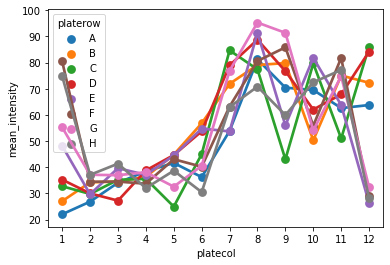

In [191]:
sns.pointplot(data=grouped, x='platecol', y='mean_intensity', hue='platerow');

That library is very extensive and allows to very easily create complex statistical plots. For example we can create box plots for our full dataset to estimate dispersion:

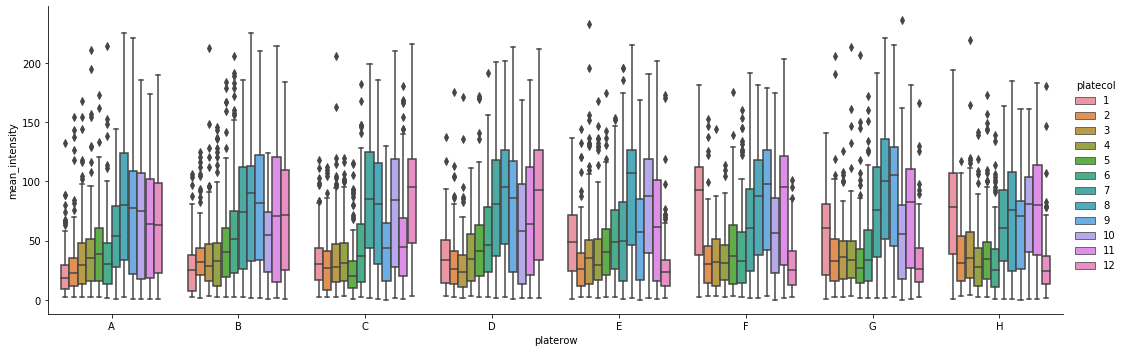

In [190]:
sns.catplot(data=all_results, aspect=3, kind='box', x='platerow', y='mean_intensity',hue='platecol');

[Plotnine](https://plotnine.readthedocs.io/en/stable/) is an other example of advanced plotting library and is actually an almost 1:1 port of ggplot to Python:

In [192]:
import plotnine as p9

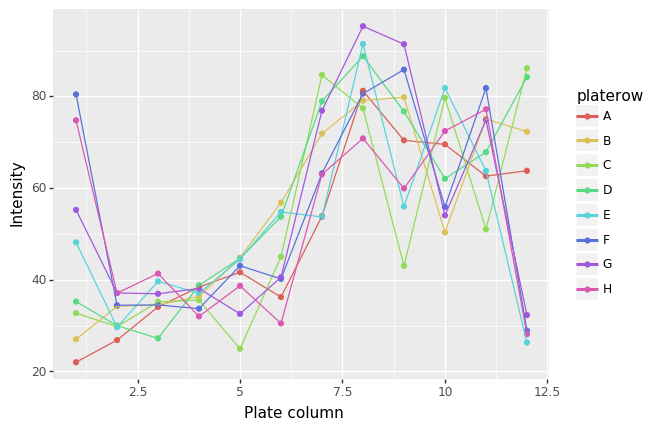

<ggplot: (322850383)>

In [198]:
(
    p9.ggplot(grouped, p9.aes(x='platecol', y='mean_intensity', color='platerow'))
    + p9.geom_point()
    + p9.geom_line()
    + p9.xlab('Plate column')
    + p9.ylab('Intensity')
)